In [ ]:
# installing enrichrpy
!pip install enrichrpy

  Preparing metadata (setup.py) ... done
  Created wheel for enrichrpy: filename=enrichrpy-0.1.0-py3-none-any.whl size=4953 sha256=9b27da166c1f34ab09af3ceca083caa97d5353eca748f25430697e40991c5cc5
  Stored in directory: /root/.cache/pip/wheels/c9/56/30/81b7cfb2669958606d5e0c89926b95719292fd5dbba044a656
Successfully built enrichrpy


In [ ]:
import enrichrpy.enrichr as een
import enrichrpy.plotting as epl
import numpy as np

define some test genes

In [ ]:
!pip install scanpy
!pip install anndata
!pip3 install igraph
!pip3 install leidenalg
!pip install scikit-network

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=387696c964180a11bd896d6b835e7038d9df5d7eefdedd1467687d8532e1ebf5
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 31.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scanpy as sc
import pandas as pd

adata_human = sc.read_mtx('/content/drive/MyDrive/FCBB/GSE127465_human_counts_normalized_54773x41861.mtx')
adata_mouse = sc.read_mtx('/content/drive/MyDrive/FCBB/GSE127465_mouse_counts_normalized_15939x28205.mtx')

# Load gene names and metadata and replace the default variable names with them
gene_names_human = pd.read_csv('/content/drive/MyDrive/FCBB/GSE127465_gene_names_human_41861.tsv.gz', header=None, sep='\t')
gene_names_human[0] = gene_names_human[0].str.upper()
adata_human.var_names = gene_names_human[0]
adata_human.var_names_make_unique()
gene_names_mouse = pd.read_csv('/content/drive/MyDrive/FCBB/GSE127465_gene_names_mouse_28205.tsv.gz', header=None, sep='\t')
gene_names_mouse[0] = gene_names_mouse[0].str.upper()
adata_mouse.var_names = gene_names_mouse[0]
adata_mouse.var_names_make_unique()

human_metadata = pd.read_csv('/content/drive/MyDrive/FCBB/GSE127465_human_cell_metadata_54773x25.tsv', sep='\t')
mouse_metadata = pd.read_csv('/content/drive/MyDrive/FCBB/GSE127465_mouse_cell_metadata_15939x12.tsv', sep='\t')
adata_human.obs = human_metadata
adata_mouse.obs = mouse_metadata

In [ ]:
#prepare dataframe, aggregate into psuedo-bulks w/ three pseudoreplicates each

mouse_set = set(gene_names_human[0])
human_set = set(gene_names_mouse[0])
common_genes = mouse_set.intersection(human_set)

common_genes = sorted(common_genes)
adata_human = adata_human[:, common_genes]
adata_mouse = adata_mouse[:, common_genes]

adata_human_cancer = adata_human[adata_human.obs['Tissue'] == 'tumor']
adata_mouse_cancer = adata_mouse[adata_mouse.obs['Tumor or healthy'] == 't']

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse

In [ ]:
#MOUSE PSEUDOREPLICATES
# Assuming adata_mouse_cancer.X is a dense matrix or a sparse matrix

# Convert the data matrix to dense if it's sparse
if issparse(adata_mouse_cancer.X):
    data_matrix = adata_mouse_cancer.X.toarray()
else:
    data_matrix = adata_mouse_cancer.X

# Get the total number of cells
num_cells = data_matrix.shape[0]

# Shuffle the cell indices
shuffled_indices = np.random.permutation(num_cells)

# Split indices into 3 pseudo-replicates
split_indices = np.array_split(shuffled_indices, 3)

# Sum the expression counts for each pseudo-replicate
pseudo_bulks = [data_matrix[idx, :].sum(axis=0) for idx in split_indices]

# Convert the list of sums into a DataFrame
pseudo_bulks_mouse = pd.DataFrame(pseudo_bulks).T  # Transpose to have genes as rows
pseudo_bulks_mouse.columns = ['Mouse_PR1', 'Mouse_PR2', 'Mouse_PR3']

# Add the gene names as the DataFrame index if adata_mouse_cancer has var_names
pseudo_bulks_mouse.index = adata_mouse_cancer.var_names


In [ ]:
#HUMAN PSEUDOREPLICATES

# Convert the data matrix to dense if it's sparse
if issparse(adata_human_cancer.X):
    data_matrix = adata_human_cancer.X.toarray()
else:
    data_matrix = adata_human_cancer.X

# Get the total number of cells
num_cells = data_matrix.shape[0]

# Shuffle the cell indices
shuffled_indices = np.random.permutation(num_cells)

# Split indices into 3 pseudo-replicates
split_indices = np.array_split(shuffled_indices, 3)

# Sum the expression counts for each pseudo-replicate
pseudo_bulks = [data_matrix[idx, :].sum(axis=0) for idx in split_indices]

# Convert the list of sums into a DataFrame
pseudo_bulks_Human = pd.DataFrame(pseudo_bulks).T  # Transpose to have genes as rows
pseudo_bulks_Human.columns = ['Human_PR1', 'Human_PR2', 'Human_PR3']

# Add the gene names as the DataFrame index if adata_mouse_cancer has var_names
pseudo_bulks_Human.index = adata_human_cancer.var_names



In [ ]:
combined_data = pseudo_bulks_Human.join(pseudo_bulks_mouse, how='inner')

#forcibly round normalized data to into to simulate raw data (temporarily fix)
raw_counts = combined_data.round().astype(int)

Querying genes against the MSigDB_Hallmark_2020 gene set library

In [ ]:
df = een.get_pathway_enrichment(common_genes, gene_set_library='MSigDB_Hallmark_2020')
df

,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value
0,1,Myogenesis,1.003997e-16,13.950947,5.139162e+02,"[EIF4A2, RB1, APP, VIPR1, SPARC, ENO3, MYLK, G...",3.161313e-15,0,0
1,2,Mitotic Spindle,1.264525e-16,13.878868,5.080591e+02,"[TRIO, ITSN1, SMC3, SMC4, UXT, PREX1, OPHN1, P...",3.161313e-15,0,0
2,3,Inflammatory Response,1.142564e-15,11.100564,3.819205e+02,"[NPFFR2, IFITM1, AQP9, SERPINE1, ICAM4, SLC4A4...",1.904273e-14,0,0
3,4,TNF-alpha Signaling via NF-kB,1.078313e-14,9.200337,2.958901e+02,"[SERPINE1, ICAM1, IFIT2, MYC, ZC3H12A, NAMPT, ...",1.347891e-13,0,0
4,5,Estrogen Response Early,8.680841e-14,7.843056,2.358805e+02,"[ABAT, NADSYN1, AQP3, TSKU, RAPGEFL1, SOX3, GJ...",8.680841e-13,0,0
5,6,Adipogenesis,6.085394e-13,6.825117,1.919749e+02,"[SCARB1, SLC27A1, MTCH2, PHLDB1, ACAA2, ITSN1,...",3.803371e-12,0,0
6,7,Epithelial Mesenchymal Transition,6.085394e-13,6.825117,1.919749e+02,"[OXTR, SPARC, COL16A1, SERPINE2, WIPF1, SERPIN...",3.803371e-12,0,0
7,8,Glycolysis,6.085394e-13,6.825117,1.919749e+02,"[CHPF, MPI, XYLT2, HDLBP, PLOD2, IRS2, ENO1, P...",3.803371e-12,0,0
8,9,Myc Targets V1,3.773705e-12,6.033405,1.586964e+02,"[EIF4A1, HDDC2, RPL34, HNRNPU, HNRNPR, PWP1, P...",2.096503e-11,0,0
9,10,IL-2/STAT5 Signaling,4.633018e-12,6.001427,1.566241e+02,"[IFITM3, CD86, CYFIP1, RNH1, CD83, CSF2, CSF1,...",2.316509e-11,0,0


There are two main GSEA plots available, bar and dot

In [ ]:
epl.enrichment_barplot(df, n=20)

alt.LayerChart(...)

In [ ]:
epl.enrichment_dotplot(df, n=20, hue='Z-score', log=True)

alt.LayerChart(...)

Differential Expression Analysis with PyDeSeq2


In [ ]:
%pip install pydeseq2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import pandas as pd

In [ ]:
#exclude genes with no counts
raw_counts = raw_counts[raw_counts.sum(axis = 1) > 0]

#Transpose
counts = raw_counts.T

#Create specific metadata
metadata = pd.DataFrame(zip(counts.index,['H','H','H','M','M','M']),columns = ['Sample','Condition'])

metadata = metadata.set_index('Sample')

counts

,A1BG,A1CF,A2M,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Human_PR1,107,66,3367,0,142,5,266,595,34,32,...,158,259,112,256,291,120,1036,3832,1886,495
Human_PR2,95,75,3292,0,153,4,326,656,11,16,...,213,288,135,230,336,133,1207,3791,1886,464
Human_PR3,77,71,3004,0,165,3,276,550,15,23,...,205,279,156,217,252,148,1095,3847,1785,516
Mouse_PR1,4,6,5,16,55,11,146,326,13,5,...,90,21,240,176,136,3,784,2421,537,332
Mouse_PR2,3,13,5,9,44,5,227,199,7,5,...,123,15,210,185,184,7,699,2412,657,322
Mouse_PR3,7,8,8,14,68,8,175,251,9,0,...,102,25,291,165,154,4,631,2370,673,318


In [ ]:
dds = DeseqDataSet(counts=counts,
             metadata=metadata,
             design_factors = "Condition")

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 21.01 seconds.

Fitting dispersion trend curve...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 20.93 seconds.

Fitting LFCs...
... done in 9.32 seconds.

Replacing 0 outlier genes.



In [ ]:
#comparing mouse to human
stat_res = DeseqStats(dds,contrast = ('Condition','M','H'))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition M vs H
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG       30.752566       -2.759095  0.514183  -5.365977   8.051235e-08   
A1CF       27.998319       -1.416571  0.444821  -3.184587   1.449608e-03   
A2M       933.259546       -7.511190  0.349241 -21.507164  1.334168e-102   
A3GALT2    11.027008        7.700528  2.038284   3.777946   1.581273e-04   
A4GALT     91.413725        0.095371  0.235792   0.404472   6.858660e-01   
...              ...             ...       ...        ...            ...   
ZYG11A     42.483424       -3.283481  0.480404  -6.834835   8.209949e-12   
ZYG11B    918.243399        0.897574  0.099195   9.048619   1.447877e-19   
ZYX      3137.731420        0.885869  0.049159  18.020313   1.349788e-72   
ZZEF1    1061.526852       -0.016512  0.090962  -0.181526   8.559550e-01   
ZZZ3      416.410940        0.955493  0.108156   8.834373   1.006609e-18   

                  padj  
A1BG   

... done in 5.36 seconds.



In [ ]:
res = stat_res.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,30.752566,-2.759095,0.514183,-5.365977,8.051235e-08,1.678766e-07
A1CF,27.998319,-1.416571,0.444821,-3.184587,1.449608e-03,2.225560e-03
A2M,933.259546,-7.511190,0.349241,-21.507164,1.334168e-102,1.964373e-101
A3GALT2,11.027008,7.700528,2.038284,3.777946,1.581273e-04,2.641153e-04
A4GALT,91.413725,0.095371,0.235792,0.404472,6.858660e-01,7.200047e-01
...,...,...,...,...,...,...
ZYG11A,42.483424,-3.283481,0.480404,-6.834835,8.209949e-12,2.079063e-11
ZYG11B,918.243399,0.897574,0.099195,9.048619,1.447877e-19,4.927392e-19
ZYX,3137.731420,0.885869,0.049159,18.020313,1.349788e-72,1.401606e-71
ZZEF1,1061.526852,-0.016512,0.090962,-0.181526,8.559550e-01,8.744446e-01


PCA Analysis

In [ ]:
import scanpy as sc

In [ ]:
sc.tl.pca(dds)

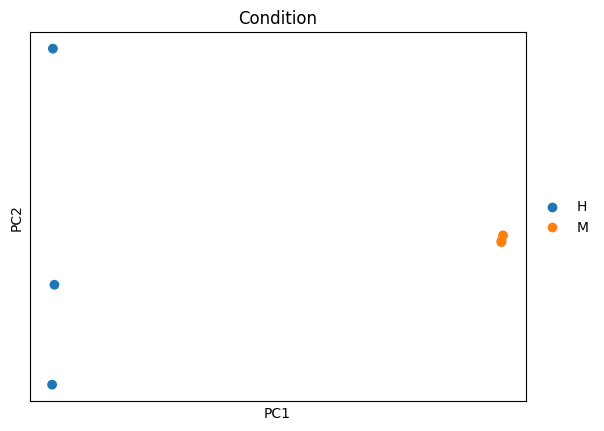

In [ ]:
sc.pl.pca(dds,color = 'Condition',size = 200)

GSEA Analysis

In [ ]:
%pip install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00


In [ ]:
#GSEA
import gseapy as gp
from gseapy.plot import gseaplot

In [ ]:
#generate ranked dataframe
ranking = res[['stat']].dropna().sort_values('stat',ascending = False)
ranking

,stat
PTGFRN,93.616331
PIM1,88.073320
GABARAP,80.511648
CRIP1,77.560313
EMD,74.134928
...,...
RPL28,-93.706378
RPL37,-94.710573
RPS13,-94.842771
TTC19,-97.225095


In [ ]:
pre_res = gp.prerank(rnk = ranking, gene_sets = ['MSigDB_Hallmark_2020'],seed = 6,permutation_num = 100)


2024-04-21 20:35:00,461 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

,Term,fdr,es,nes
0,MSigDB_Hallmark_2020__Myc Targets V1,0.000000,-0.498701,-2.071911
1,MSigDB_Hallmark_2020__Angiogenesis,0.000000,-0.573997,-1.782280
2,MSigDB_Hallmark_2020__p53 Pathway,0.000000,-0.425735,-1.771932
3,MSigDB_Hallmark_2020__Epithelial Mesenchymal T...,0.000000,-0.494224,-2.032638
4,MSigDB_Hallmark_2020__Estrogen Response Early,0.000000,-0.416692,-1.753189
5,MSigDB_Hallmark_2020__Apoptosis,0.000000,-0.441455,-1.775624
6,MSigDB_Hallmark_2020__IL-6/JAK/STAT3 Signaling,0.000000,0.540210,1.970835
7,MSigDB_Hallmark_2020__TNF-alpha Signaling via ...,0.000000,-0.472055,-1.926953
8,MSigDB_Hallmark_2020__Hypoxia,0.001936,-0.418693,-1.682620
9,MSigDB_Hallmark_2020__Androgen Response,0.003442,-0.455929,-1.654542


In [ ]:
out_df.sort_values('nes').iloc[0].Term

'MSigDB_Hallmark_2020__Myc Targets V1'

In [ ]:
pre_res.res2d.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MSigDB_Hallmark_2020__Myc Targets V1,-0.498701,-2.071911,0.0,0.0,0.0,90/191,21.79%,RPL34;RPS2;HNRNPA1;RPS6;HSPD1;RPS10;PABPC1;DDX...
1,prerank,MSigDB_Hallmark_2020__Epithelial Mesenchymal T...,-0.494224,-2.032638,0.0,0.0,0.0,88/192,19.85%,COL1A1;TNFAIP3;VIM;PLAUR;AREG;SAT1;COL3A1;COL1...
2,prerank,MSigDB_Hallmark_2020__IL-6/JAK/STAT3 Signaling,0.54021,1.970835,0.0,0.0,0.0,23/85,7.45%,PIM1;CSF2RB;IL1R2;CSF3R;CCR1;IL1B;IRF9;CD14;CR...
3,prerank,MSigDB_Hallmark_2020__TNF-alpha Signaling via ...,-0.472055,-1.926953,0.0,0.0,0.0,66/194,10.60%,SOD2;NR4A2;SLC2A3;NR4A3;BIRC3;LITAF;NAMPT;FOSB...
4,prerank,MSigDB_Hallmark_2020__Angiogenesis,-0.573997,-1.78228,0.0,0.0,0.0,13/35,7.29%,THBD;COL3A1;OLR1;LRPAP1;VCAN;TIMP1;SPP1;LUM;PT...
5,prerank,MSigDB_Hallmark_2020__Apoptosis,-0.441455,-1.775624,0.0,0.0,0.0,50/156,11.31%,SOD2;LMNA;BIRC3;HSPB1;SAT1;DNAJA1;ANXA1;EREG;C...
6,prerank,MSigDB_Hallmark_2020__p53 Pathway,-0.425735,-1.771932,0.0,0.0,0.0,67/188,16.54%,RPS12;RPL36;CTSD;CD81;NDRG1;LDHB;SAT1;S100A10;...
7,prerank,MSigDB_Hallmark_2020__Estrogen Response Early,-0.416692,-1.753189,0.0,0.0,0.0,59/193,13.58%,PPIF;FKBP5;AREG;TFF1;KRT19;AQP3;KRT8;NBL1;MUC1...
8,prerank,MSigDB_Hallmark_2020__Hypoxia,-0.418693,-1.68262,0.0,0.001936,0.01,46/187,6.57%,GAPDH;SLC2A3;CXCR4;TNFAIP3;IRS2;PLAUR;IDS;PFKF...
9,prerank,MSigDB_Hallmark_2020__Androgen Response,-0.455929,-1.654542,0.0,0.003442,0.02,31/92,10.80%,FKBP5;B2M;NDRG1;INSIG1;ELL2;SAT1;KRT19;XRCC6;X...


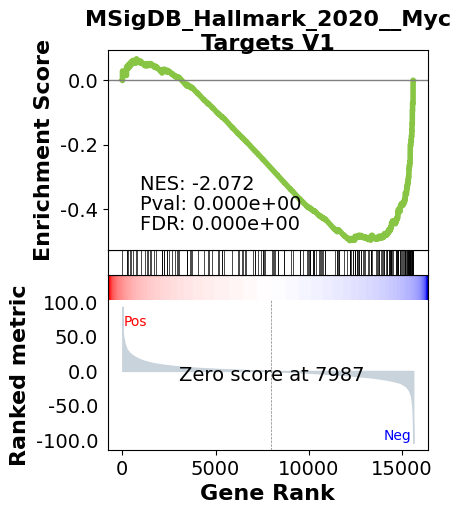

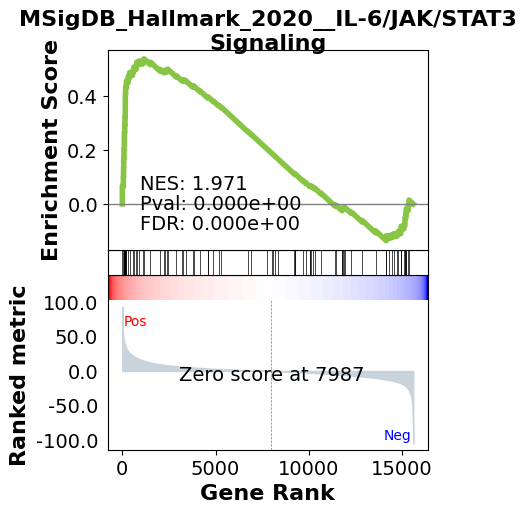

In [ ]:
#single geneset plot

terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0]) # v1.0.5
gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])


terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[2]) # v1.0.5
gseaplot(rank_metric=pre_res.ranking, term=terms[2], ofname='your.plot.pdf', **pre_res.results[terms[2]])

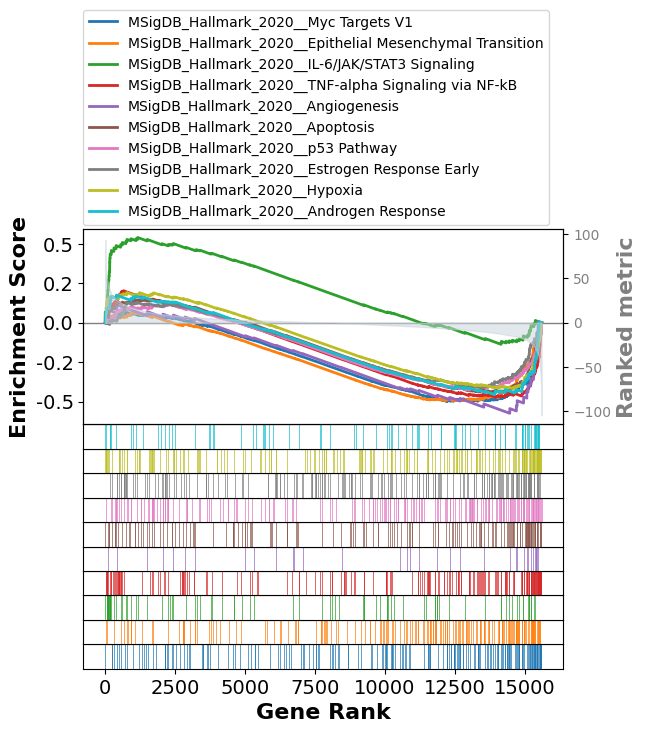

In [ ]:
#multiple pathways at once
axs = pre_res.plot(terms=terms[0:10],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )
# or use this to have more control on the plot
# from gseapy import gseaplot2
# terms = pre_res.res2d.Term[1:5]
# hits = [pre_res.results[t]['hits'] for t in terms]
# runes = [pre_res.results[t]['RES'] for t in terms]
# fig = gseaplot2(terms=terms, ress=runes, hits=hits,
#               rank_metric=gs_res.ranking,
#               legend_kws={'loc': (1.2, 0)}, # set the legend loc
#               figsize=(4,5)) # rank_metric=pre_res.ranking

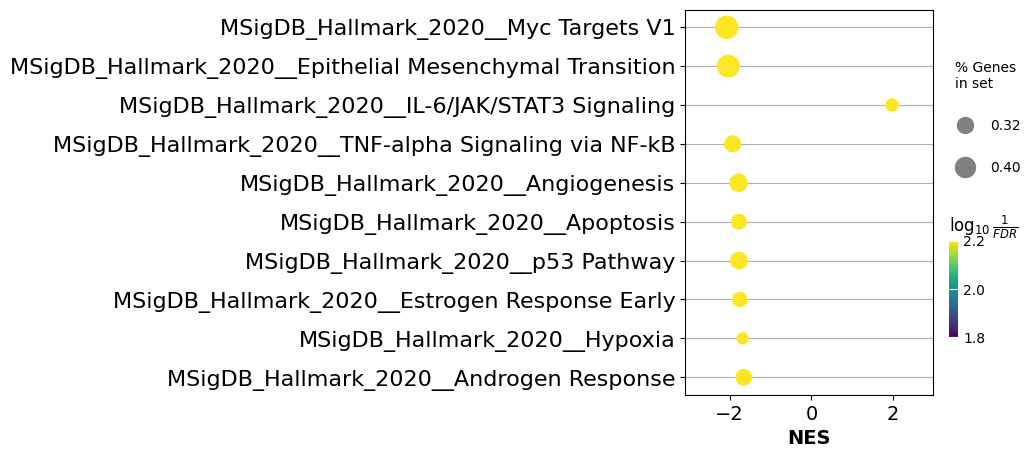

In [ ]:
#gsea dotplot
import matplotlib.pyplot as plt
from gseapy import dotplot
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title='',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


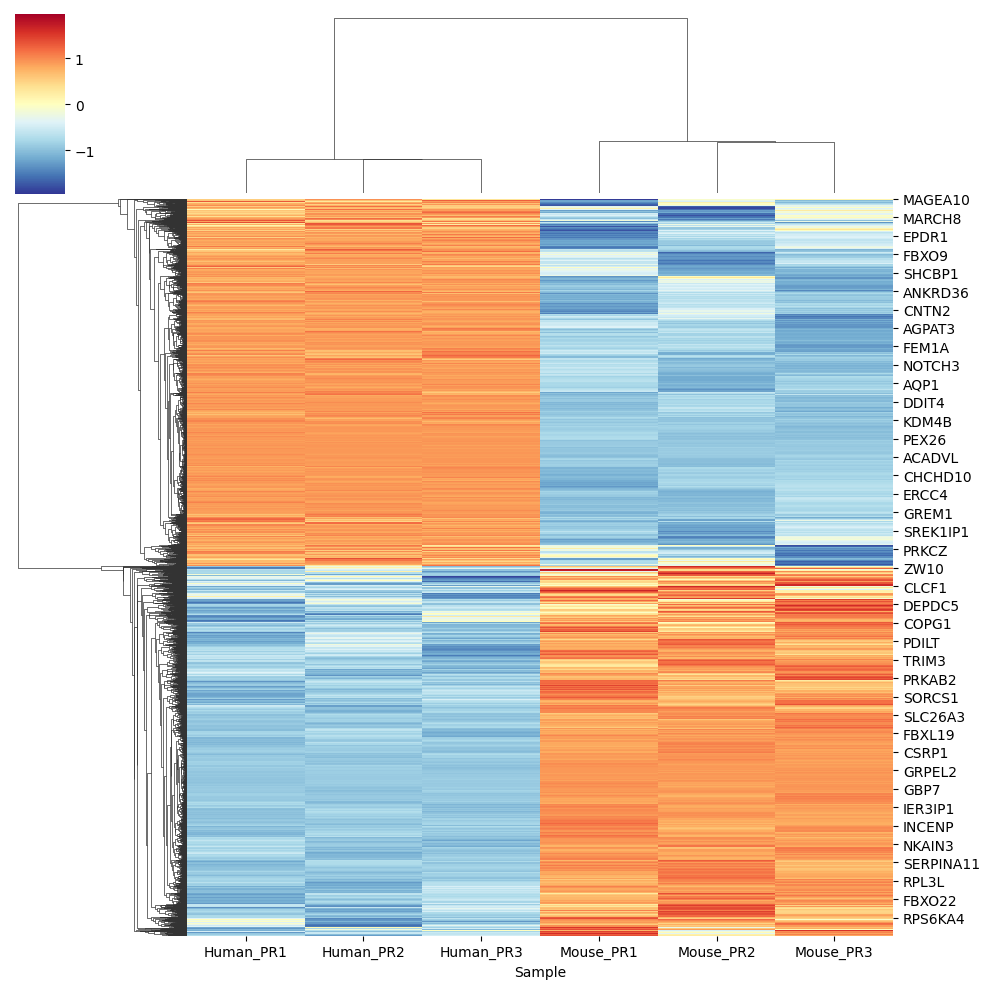

In [ ]:
# heatmap visualization
import seaborn as sns
dds.layers['normed_counts']
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]
dds_sigs = dds[:, sigs.index]
dds_sigs
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)
sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')

In [ ]:
#volcano
%pip install sanbomics
from sanbomics.plots import volcano

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


/usr/local/lib/python3.10/dist-packages/sanbomics/plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pvalue][df[pvalue] == 0] = 1e-323


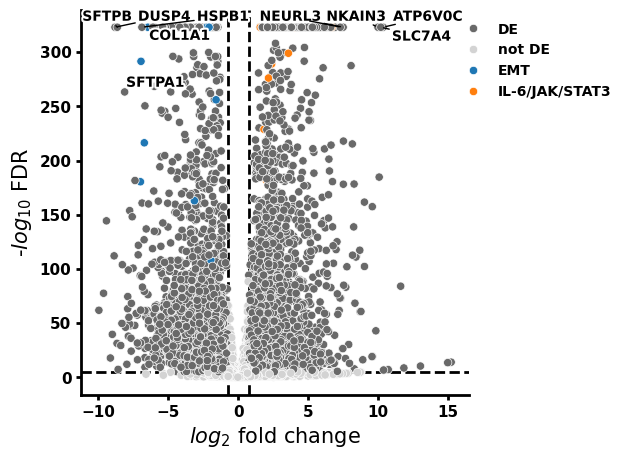

In [ ]:
res.index.name = 'Symbol'
res_reset = res.reset_index()
a = ['VIM','COL1A1','PLAUR','SPP1','TNFAIP3','AREG','COL3A1','VCAN','COL1A2','SAT1']
b = ['PIM1','IL1R2','CCR1','CSF2RB','CD14','IRF9','CD9','IL1B','ITGA4','PTPN1','CRLF2','CSF2RA','CSF3R','IL17RA']
volcano(res_reset, pval_thresh = 0.00001, symbol='Symbol',color_dict = {'EMT':a,'IL-6/JAK/STAT3':b})

In [ ]:
import pydeseq2 as dseq
print(gp.__version__)
print(dseq.__version__)

1.1.2
0.4.8


Network visualization

In [ ]:
from gseapy import enrichment_map
# return two dataframe
nodes, edges = enrichment_map(pre_res.res2d)


In [ ]:
%pip install networkx

In [ ]:
import networkx as nx

In [ ]:
# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

ValueError: s must be a scalar, or float array-like with the same size as x and y

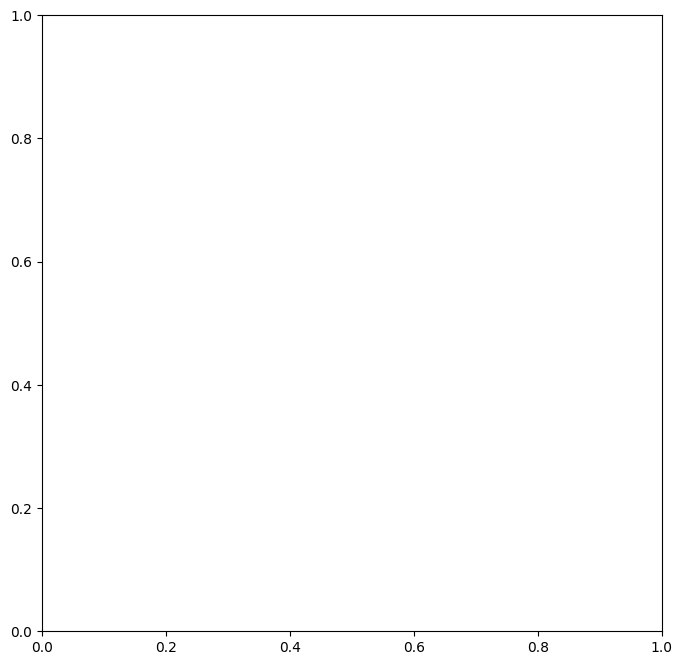

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node

node_sizes = nodes.Hits_ratio * 1000
node_sizes = np.nan_to_num(node_sizes)

nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=node_sizes)
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()